In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.vision import *
from fastai.callbacks import *
from fastai.widgets import *

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [9]:
flg_grey = False

def get_data(sz, bs):

    tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=0.3, max_zoom=1.3, max_lighting=0.4, max_warp=0.2, p_affine=0.75,
                          p_lighting=0.75,xtra_tfms=zoom_crop(scale=(0.6,1.3), do_rand=True, p=0.6))
    
    src = (ImageList.from_folder( path='/kaggle/input/hepeople-ex/Train_New')
           .split_by_rand_pct(0.20) #split_none() 
           .label_from_folder()
           .add_test_folder('../Test'))

    data = (src.transform(tfms, size=sz,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=bs, device= torch.device('cuda:0')).normalize(imagenet_stats))

    if flg_grey:
        for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
            itemList = getattr(data, itemList)
            if itemList: itemList.x.convert_mode = "L"
    
    return data

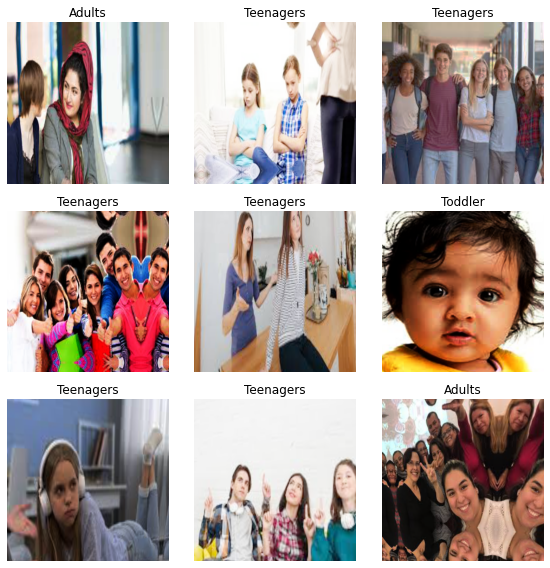

In [10]:
np.random.seed(60)
torch.manual_seed(60) # cpu  vars


data=get_data(299,32)
data.show_batch(rows=3, figsize=(8,8))

In [11]:
print(data.classes)
torch.cuda.empty_cache()

['Adults', 'Teenagers', 'Toddler']


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.45E-02


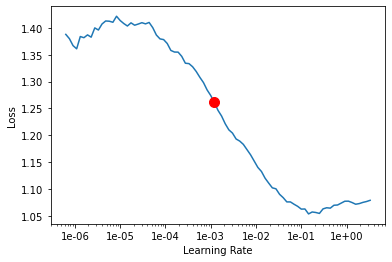

In [12]:
learn = cnn_learner(data=data, base_arch=models.resnet152,bn_final=True, metrics= error_rate,callback_fns=ShowGraph).mixup()
#lets find the correct learning rate to be used from lr finder
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.918860,0.592455,0.243494,00:46
1,0.805512,0.531317,0.204461,00:44
2,0.726616,0.444760,0.167286,00:44
3,0.670631,0.383940,0.144981,00:45
4,0.596906,0.272538,0.083643,00:44
5,0.559021,0.264315,0.083643,00:45
6,0.530115,0.220811,0.055762,00:44
7,0.521366,0.208267,0.053903,00:45
8,0.508790,0.203755,0.057621,00:45
9,0.509054,0.200966,0.059480,00:45


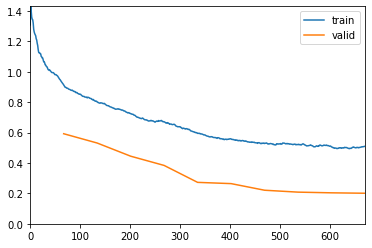

In [13]:
lr = 7e-3
learn.fit_one_cycle(10,wd=0.05, max_lr =slice(lr))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-06


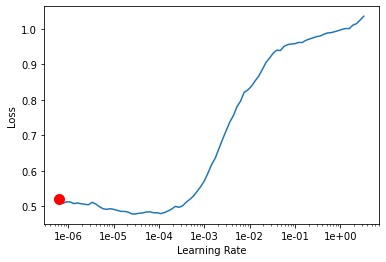

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.477114,0.181017,0.050186,00:56
1,0.488395,0.171741,0.048327,00:56
2,0.488514,0.196240,0.061338,00:56
3,0.454930,0.138058,0.026022,00:56
4,0.456375,0.119075,0.026022,00:56
5,0.437082,0.112610,0.018587,00:56
6,0.418914,0.113193,0.024164,00:56
7,0.404940,0.108504,0.018587,00:56


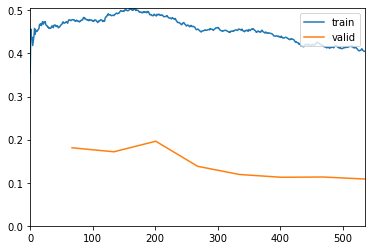

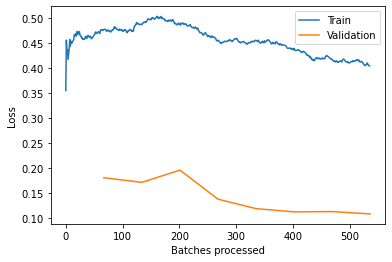

In [15]:
learn.fit_one_cycle(8,max_lr = slice(7e-6,1e-3/3))
learn.recorder.plot_losses()

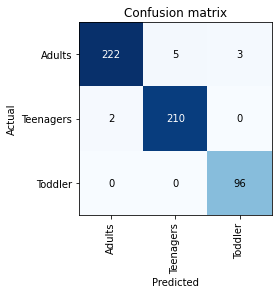

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-07


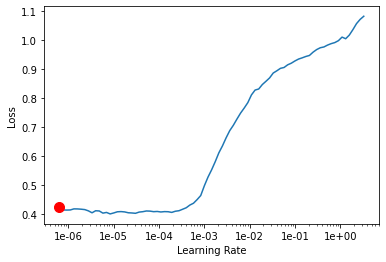

In [17]:
learn.freeze_to(-10)

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.404115,0.110145,0.020446,00:56
1,0.412394,0.109983,0.022305,00:56
2,0.404912,0.112424,0.018587,00:56
3,0.408676,0.099768,0.018587,00:57
4,0.399562,0.098388,0.018587,00:57


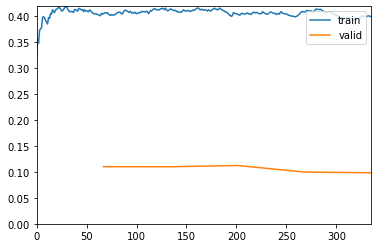

In [23]:
learn.fit_one_cycle(5, slice(7e-07, lr/15),wd=0.15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 7.59E-08


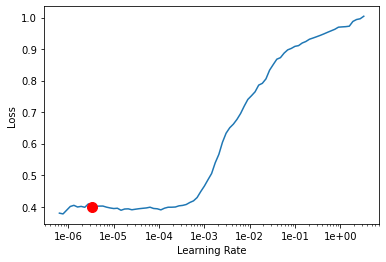

In [24]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.384784,0.100692,0.018587,00:57
1,0.379946,0.103508,0.018587,00:57
2,0.398566,0.096316,0.018587,00:56
3,0.391816,0.099906,0.018587,00:56


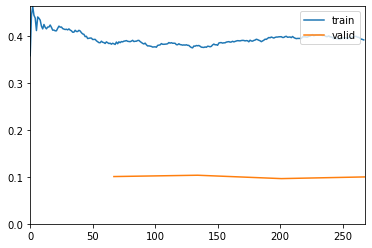

In [25]:
learn.fit_one_cycle(4,max_lr= slice(2e-5),wd=0.05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


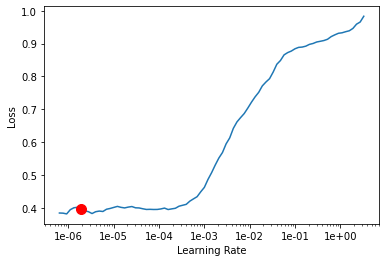

In [26]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.399318,0.099344,0.018587,00:53
1,0.397214,0.098779,0.018587,00:53
2,0.406431,0.100643,0.018587,00:53
3,0.398666,0.100541,0.018587,00:53


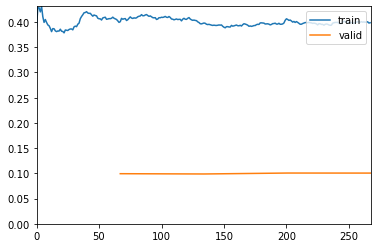

In [27]:
learn.fit_one_cycle(4, slice(3e-06))

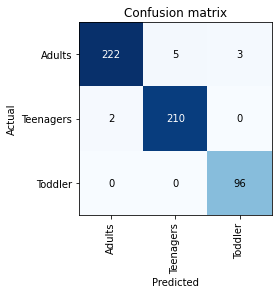

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs)

In [29]:
learn.export()
fnames = [str(x)[str(x).rfind('/')+1:] for x in data.test_ds.items[:]]

In [30]:
#preds, _ = learn.get_preds(ds_type=DatasetType.Test)  
preds, _ = learn.TTA(ds_type=DatasetType.Test) #TTA performs better

labels = np.argmax(preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

In [31]:
df_final = pd.DataFrame(list(zip(fnames, test_predictions_direct)),  columns =['Filename', 'Category']) 
df_final.to_csv('submission.csv', index=False)